![OpenSARlab notebook banner](NotebookAddons/blackboard-banner.png)

# Subset Data Stack

### Alex Lewandowski; University of Alaska Fairbanks

<img style="padding: 7px" src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right"/></font>

This notebook crops a directory of tiffs to a subset area of interest using an interactive Matplotlib plot of an image in your data stack.
This notebook assumes that users have generated the original image from `Prepare_Data_Stack` notebook. Users now have an option to subset the original image in following methods:

1. Drag and drop to cut out sqare shape
1. Given a correct Well-Known Text (WKT), users can define and cut a specific polygon shape.
1. Upload shapely file along with its relavent files to cut a specific polygon.

<!-- <img style="padding: 7px" src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right"/></font> -->


---

<font face="Calibri" size="5" color="darkred"> <b>Important Note about JupyterHub</b> </font>

**Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.**


In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [2]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/rtc_analysis':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "rtc_analysis" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select the "rtc_analysis" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "rtc_analysis" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))


--- 
    
## 0. Importing Relevant Python Packages

In this notebook we will use the following scientific library:

- [GDAL](https://www.gdal.org/) is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.

**Import the necesssary libraries and modules:**


In [3]:
%%capture
from pathlib import Path
import json # for loads
import shutil

from osgeo import gdal
import pyproj 

from IPython.display import Markdown
from IPython.display import display
%matplotlib widget

from ipyfilechooser import FileChooser

import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 12})

import opensarlab_lib as asfn
asfn.jupytertheme_matplotlib_format()


---
**Write functions to gather and print individual tiff paths:**

In [4]:
def get_tiff_paths(paths):
    tiff_paths = list(paths.parent.rglob(paths.name))    
    tiff_paths.sort()
    return tiff_paths

def print_tiff_paths(tiff_paths):
    print("Tiff paths:")
    for p in tiff_paths:
        print(f"{p}\n")

## Select the directory holding your tiffs and dems
- Click the `Select` button
- Navigate to your data directory
- Click the `Select` button
- Confirm that the desired path appears in green text
- Click the `Change` button to alter your selection
- *Note: If you used `Prepare_Data_Stack_Hyp3` notebook to generate directory, tiffs should be in `RTC_GAMMA_tiffs` directory.*

In [5]:
fc = FileChooser(Path.cwd())
display(fc)

FileChooser(path='/home/jovyan/Hydrosar', filename='', title='', show_hidden=False, select_desc='Select', chan…

### Select the jobs you want to crop

In [6]:
job_types = ['RTC_GAMMA', 'INSAR_GAMMA', 'AUTORIFT']
job_type = asfn.select_parameter(job_types)
job_type

RadioButtons(layout=Layout(min_width='800px'), options=('RTC_GAMMA', 'INSAR_GAMMA', 'AUTORIFT'), value='RTC_GA…

**Determine the path to the analysis directory containing the tiff directory:**

In [7]:
# Define the directory path
directory_path = Path(fc.selected_path)

def folder_finder(desired_ending):
    # Find the folder that ends with the desired ending
    matching_folders = list(directory_path.glob(f"*{desired_ending}"))
    # Get the first matching folder (assuming there is only one)
    if matching_folders:
        return matching_folders[0]

tiff_dir = folder_finder('tiffs')
tiff_dir_dem = folder_finder('dems')
analysis_dir = tiff_dir.parent
print(f"analysis_dir: {analysis_dir}")




paths = tiff_dir/"*.tif*"
paths_dem = tiff_dir_dem/"*.tif*"
tiff_paths = get_tiff_paths(paths)
tiff_paths_dem = get_tiff_paths(paths_dem)

analysis_dir: /home/jovyan/Hydrosar/Dataset/Cambodia


**Determine the UTM zone for your images.** 

This assumes you have already reprojected multiple UTM projections to a single predominant projection using the `Prepare_Data_Stack_Hyp3` notebook.

In [8]:
# Note - you should only have files that ends with .tif in same format
info = gdal.Info(str(tiff_paths[0]), format='json')
info = info['coordinateSystem']['wkt']
utm = info.split('ID')[-1].split(',')[1][0:-2]
print(f"UTM Zone: {utm}")

UTM Zone: 32648


/home/jovyan/.local/envs/rtc_analysis/lib/python3.9/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [9]:
print_tiff_paths(tiff_paths)

Tiff paths:
/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171015T111116_DVP_RTC30_G_gpufem_C4E1_VH.tif

/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171015T111116_DVP_RTC30_G_gpufem_C4E1_VV.tif

/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171027T111116_DVP_RTC30_G_gpufem_474A_VH.tif

/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171027T111116_DVP_RTC30_G_gpufem_474A_VV.tif

/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171108T111116_DVP_RTC30_G_gpufem_20BA_VH.tif

/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171108T111116_DVP_RTC30_G_gpufem_20BA_VV.tif

/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171120T111116_DVP_RTC30_G_gpufem_25A1_VH.tif

/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171120T111116_DVP_RTC30_G_gpufem_25A1_VV.tif

/home/jovyan/Hydrosar/Dataset/Cambod

**Create a string containing paths to one image for each area represented in the stack:**

In [10]:
to_merge = {}
for pth in tiff_paths:
    
    if 'subset' in str(pth):
        continue
    
    info = (gdal.Info(str(pth), options = ['-json']))
    info = json.dumps(info)
    info = (json.loads(info))['wgs84Extent']['coordinates']
    
    coords = [info[0][0], info[0][3]]
    for i in range(0, 2):
        for j in range(0, 2):
            coords[i][j] = round(coords[i][j])
    str_coords = f"{str(coords[0])}{str(coords[1])}"
    if str_coords not in to_merge:
        to_merge.update({str_coords: pth})
merge_paths = ""
for pth in to_merge:
    merge_paths = f"{merge_paths} {to_merge[pth]}"
    
print(merge_paths)

 /home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171015T111116_DVP_RTC30_G_gpufem_C4E1_VH.tif


**Merge the images for display in the Area-Of-Interest selector:**

In [11]:
full_scene = analysis_dir/'full_scene.tif'

if full_scene.exists():
    full_scene.unlink()
    
gdal_command = f"gdal_merge.py -o {full_scene} {merge_paths}"
!{gdal_command}

0...10...20...30...40...50...60...70...80...90...100 - done.


---
## Subset The Tiffs

**Create a Virtual Raster Stack:**

In [12]:
image_file = f"{analysis_dir}/raster_stack.vrt"
!gdalbuildvrt -separate $image_file -overwrite $full_scene

0...10...20...30...40...50...60...70...80...90...100 - done.


**Convert the VRT into an array:**

In [13]:
img = gdal.Open(image_file)
rasterstack = img.ReadAsArray()

**Print the number of bands, pixels, and lines:**

In [14]:
print(img.RasterCount) # Number of Bands
print(img.RasterXSize) # Number of Pixels
print(img.RasterYSize) # Number of Lines

1
9628
7924


**Choose a best method to cutout image**

In [15]:
print("Please choose one of three options:")

option_key = [
    None,
    'Option 1: Draw rectangle with drag and drop.',
    'Option 2: Write/paste Well-Known Text (WKT).',
    'Option 3: Upload shapefile.'
]

option = asfn.select_parameter([option_key[1], option_key[2] , option_key[3],], '')
display(option)

Please choose one of three options:


RadioButtons(layout=Layout(min_width='800px'), options=('Option 1: Draw rectangle with drag and drop.', 'Optio…

In [16]:
choice = option_key.index(option.value)

### **Option 1: Create an AOI selector from an image in your raster stack:**

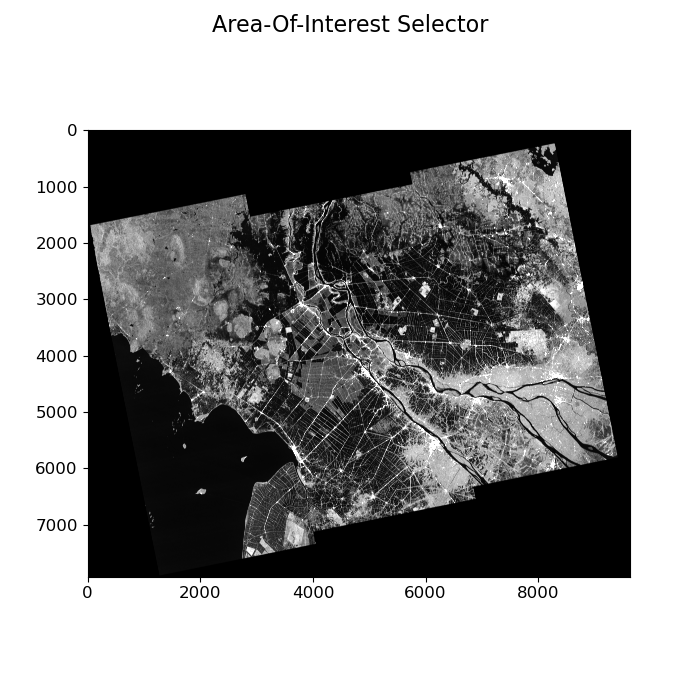

In [17]:
## this generates interactive plots (AOI subset) (option 1)
if choice == 1:
    fig_xsize = 7
    fig_ysize = 7
    aoi = asfn.AOI_Selector(rasterstack, fig_xsize, fig_ysize)

### **Option 2 & 3: Preset**

**Choose a `.tif` file to generate your shapefile**

In [18]:
if choice != 1:    
    display(Markdown(f'<text style=color:red>NOTE: As of now, your WKT/shapefile will work if it meets following conditions: </text>'))
    display(Markdown(f'<ol text style=color:red><li>Simple polygons </li> <li>Has same projection as the original image.</li></ol>'))
    display(Markdown(f'<text style=color:red>Using complex shapes (e.g. MULTIPOLYGON, POLYGON with holes, etc.) may cause an unexpected results.</text>'))

    try:
        infile = tiff_paths[0]
    except:
        raise OSError('Directory that contains your .tif files are empty.')
        
    print(infile)

**Check if you have a correct infile**

In [19]:
if choice != 1:
    try:
        suffix = infile.suffix
    except:
        raise TypeError(f'{infile} is not a valid path.')
    
    if suffix != '.tif':
        raise ValueError(f'File you chose is not a ".tif" file. Pick a valid ".tif" file.')
      
    # path to your subset image file
    outfile = str(infile.parent/f'subset_{infile.stem}.tif')

**Useful functions used in option 2 & 3:**

In [20]:
if choice != 1:
    from osgeo import osr
    
    def oldSubsetExist(directory_path) -> bool:
        """
        Given path to a directory containing old 'subset_...tif' file,
        it will determine if that subset exists in that directory or not.
        """
        for path in directory_path.iterdir():
            if 'subset_' in str(path) and path.suffix == '.tif':
                return True
            
        return False
    
    def removeOldSubset(directory_path) -> None:
        """
        Given path to a directory containing old 'subset_...tif' file,
        it will remove all instances of 'subset_...tif' file.
        """
        for path in directory_path.iterdir():
            if 'subset_' in str(path) and path.suffix == '.tif':
                print(f'Removed {path}...')
                path.unlink()

    
    # Gets EPSG from your infile
    def getEPSG(tif_path) -> int:
        try:
            Path(tif_path).exists()
        except:
            print('That .tif file does not exist. Please enter a valid path.')
            
        ds = gdal.OpenEx(tif_path)
        prj = ds.GetProjection()
        
        return int(osr.SpatialReference(prj).GetAttrValue('AUTHORITY', 1))

### **Option 2: Create subset image and `.shp`**

**Clean up previous shapely files (`.shp`, `.prj`, `.dbf`, `.shx`)**

In [21]:
if choice == 2:
    print("Would you like to remove all instances of previous/unused shapely files?")
    shp_option = asfn.select_parameter(['Yes', 'No',], '')
    display(shp_option)

In [22]:
if choice == 2 and shp_option.value == 'Yes':
    keywords = ['.shp','.dbf','.prj','.shx']
    
    for path in infile.parent.iterdir():
        for k in keywords:
            if path.suffix == k:
                print(f'Removed {path}')
                path.unlink()

**Choose a name for your `.shp` file:**

In [23]:
if choice == 2:
    shp_name = input('Choose a name for your shapefly file: ')
    
    # default name if user does not input anything
    if not shp_name:
        shp_name = 'shape'
    
    shp = str(infile.parent/f'{shp_name}.shp')
    
    print(shp)

**Generate `.shp`, `.proj`, and other relavent files.**

In [24]:
# Let user input WKT (option 2)
if choice == 2:
    from osgeo import ogr
    import shapely.wkt as sWkt
    import geopandas
    
    print("When inputting your WKT, here are few things to note:\n"\
         "\t1) If you don't already have WKT, you can use GIS software (e.g. ArcGIS) to obtain WKT for your image.\n"\
         "\t2) It will only accept single polygon (e.g. POLYGON((x y, x y, ...)). \n"\
         "\t3) Your WKT has to be based off of your original image that you wish to subset.")
    

    correctWktInput = False
    while not correctWktInput:
        wkt = input("Please enter your WKT: ")
        
        try:
            geoShape = sWkt.loads(wkt)
            series = geopandas.GeoSeries([geoShape])
            isNotConnected = series.is_valid[0]
                        
            if not isNotConnected:
                raise('Obsecure shape detected.')
                continue
                
        except:
            print('Error due to an unclosed shape, obsecure shape, or bad input. Try again...')
            continue
            
        correctWktInput = True
                
    outfile = str(infile.parent/f'subset_{infile.stem}.tif')
    epsg = getEPSG(str(infile))
#   For reference, latlong epsg = 4326

    driver = ogr.GetDriverByName('Esri Shapefile')
    ds = driver.CreateDataSource(shp)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    layer = ds.CreateLayer('', srs, ogr.wkbPolygon)
    defn = layer.GetLayerDefn()

    # Create a new feature (attribute and geometry)
    feat = ogr.Feature(defn)
    
    # Make a geometry from Shapely object
    geom = ogr.CreateGeometryFromWkt(wkt) 
    feat.SetGeometry(geom)
    
    layer.CreateFeature(feat)
    feat = geom = None  # destroy these

    # Save and close everything
    ds = layer = feat = geom = None

### **Option 3: Upload `.shp`**

If you chose option 3, upload your shapely file (`.shp`) as well as any files that are related to it (`.proj`, `.shx` and `.dbf` files). Once you uploaded them, select the .shp file using file selector. If you selected existing `.shp` it should be highlighted in orange.

**Note**: `.shp`, `.shx`, `.dbf`, and `.proj` files must be in the same directory.

In [25]:
if choice == 3:
    display(Markdown(f'<text style=color:red>WARNING: The UPLOADED .shp FILE MUST HAVE A SAME EPSG/PROJECTION AS THE ORIGINAL IMAGE.</text>'))
    display(Markdown(f'<text style=color:red>IF YOUR .shp FILE DOES NOT HAVE PROJECTION OR HAVE DIFFERENT PROJECTION FROM ORIGINAL IMAGE,</text>'))
    display(Markdown(f'<text style=color:red>IT MAY CAUSE AN UNEXPECTED RESULTS.</text>'))
    
    shpfc = FileChooser('/home/jovyan/notebooks/SAR_Training/English/Master')
    display(shpfc)

In [26]:
if choice == 3:
    try:
        shp = Path(shpfc.selected)
    except:
        raise TypeError('Please choose the file path before proceeding.')
        
    print(shp)

In [27]:
# Extract wkt from shapefile:

if choice == 3:
    if shp.suffix == '.shp':
        gInfo = gdal.OpenEx(str(shp))
        layer = gInfo.GetLayer()
        feature = layer.GetFeature(0)
        wkt = feature.GetGeometryRef().ExportToWkt()

### **Option 2 & 3: Create subset image**

**If you have subset image from previous run, it will ask you to either keep the old ones or remove and generate new.**

In [28]:
if choice != 1:
    # Check if 'subset' files from previous run exists 
    if oldSubsetExist(infile.parent):
        print('Items from previous run exists. Would you like to keep them or remove them to generate new items?')
        clean_option = asfn.select_parameter(['Clean and Generate New Items', 'Keep Old Items', ], '')
        display(clean_option)

In [29]:
if choice != 1:
        
    print(shp)
    generate_command = f'gdalwarp -cutline {shp} -crop_to_cutline {infile} {outfile}'
    
    if oldSubsetExist(infile.parent):
        if clean_option.value == 'Clean and Generate New Items':
            print('Cleaning previously generated subset file(s)...')
            removeOldSubset(infile.parent)
            print('\n')
        else:
            generate_command = f'echo Kept previous subset.'
        
    !{generate_command}

**Gather and define projection details:**

In [30]:
geotrans = img.GetGeoTransform()
projlatlon = pyproj.Proj('EPSG:4326') # WGS84
projimg = pyproj.Proj(f'EPSG:{utm}')

**Write a function to convert the pixel, line coordinates from the AOI selector into geographic coordinates in the stack's EPSG projection:**

In [31]:
# xy -> geocoords
def xy_to_geocoord(x, y, geotrans,latlon=True):    
    ref_x = geotrans[0] + (x * geotrans[1])
    ref_y = geotrans[3] + (y * geotrans[5])
    if latlon:
        ref_y, ref_x = pyproj.transform(projimg, projlatlon, ref_x, ref_y)
    return [ref_x, ref_y]

# geocoords -> xy
"""
ref_x: x geocoordinate from WKT
ref_y: y geocoordinate from WKT
"""
def geocoord_to_xy(ref_x, ref_y, geotrans):
    x = (ref_x - geotrans[0]) / geotrans[1]
    y = (ref_y - geotrans[3]) / geotrans[5]
    
    return [x,y]

**Option 2 & 3 - Write a function to display the cut out image:**

In [32]:
# Display cropped image & place cropped image on top on original image.

import numpy as np
import matplotlib.patches as patches
import re

# Display image (different option depending on options)
def displayImage(rasterstack,
                 fig_xsize=None, fig_ysize=None,
                 wkt=None,
                 cmap=plt.cm.gist_gray,
                 vmin=None, vmax=None,):

    if not vmin:
        vmin = np.nanpercentile(rasterstack, 1)
 
    if not vmax:
        vmax=np.nanpercentile(rasterstack, 99)

    if fig_xsize and fig_ysize:
        fig, current_ax = plt.subplots(figsize=(fig_xsize, fig_ysize))
    else:
        fig, current_ax = plt.subplots()
        
    current_ax.imshow(rasterstack, cmap=plt.cm.gist_gray, vmin=vmin, vmax=vmax)
    
    # If it's original image, show where it's been cropped    
    if wkt:
        showCropped(wkt, current_ax)

# Place cropped image on top of the image
def showCropped(wkt, ax):

    x,y = [],[]
    wkt_coords = [float(i) for i in (re.findall(r"[-+]?\d*\.\d+|\d+", wkt))]

    # Since "patches.Polygon" does not require last coordinate, remove last coordinate (x,y)  
    wkt_coords.pop()
    wkt_coords.pop()

    isX = True
    for c in wkt_coords:
        x.append(c) if isX else y.append(c)
        isX = not(isX)

    if len(x) == len(y):
        tmp = []

        for i in range(0, len(x)):
            tmp = geocoord_to_xy(x[i],y[i],geotrans)
            x[i],y[i] = tmp[0], tmp[1]

    poly = patches.Polygon(xy=list(zip(x,y)), linestyle='-')

    # Add the patches to the Axes
    ax.add_patch(poly)
    plt.show()


**Option 2 & 3 - Displaying original image and cropped image. If you are satisfied with the cropped image, proceed.**

In [33]:
if choice != 1:    
    
    # If file size is too big, it will not display image:
    fileSize = Path(outfile).stat().st_size
    fileSizeGB = fileSize/(1024 ** 3) # in GB
    
    if fileSizeGB > 10.00:
        raise MemoryError('Subset file too big and will crash. Please regenerate your subset image using correct values.')  
    
    # First, show the entire map, and highlight the parts where it has been cropped.
    displayImage(rasterstack,7.5,7.5,wkt)       
    
    # generalized - there should only be one 'subset' file in your directory
    cropped_img = gdal.Open(str(outfile)).ReadAsArray()
    
    # Display cropped img
    displayImage(cropped_img,7.5,7.5) 

**Option 1: Call `xy_to_geocoord` to gather the `aoi_coords`:**

In [34]:
try:
    if choice == 1:
        aoi_coords = [xy_to_geocoord(aoi.x1, aoi.y1, geotrans, latlon=False), xy_to_geocoord(aoi.x2, aoi.y2, geotrans, latlon=False)]
        print(f"aoi_coords in EPSG {utm}: {aoi_coords}")
    else:
        # make warning more visable?
        display(Markdown(f'<text style=color:red>If the image above: </text>'))
        display(Markdown(f'<ol text style=color:red><li>Does not show blue shape on the first image.</li> <li>and/or it displays entirely black image on the second</li></ol>'))
        display(Markdown(f'<text style=color:red>It indicates that there is something wrong with your input. Please use WKT or .shp file that has the same projection as original image and generate the subset image.</text>'))
        display(Markdown(f'<text style=color:blue>If both images displayed properly as you expected, please proceed ahead.</text>'))
except TypeError:
    print('TypeError')
    display(Markdown(f'<text style=color:red>This error occurs if an AOI was not selected.</text>'))
    display(Markdown(f'<text style=color:red>Note that the square tool icon in the AOI selector menu is <b>NOT</b> the selection tool. It is the zoom tool.</text>'))
    display(Markdown(f'<text style=color:red>Read the tips above the AOI selector carefully.</text>'))

aoi_coords in EPSG 32648: [[473075.1490810412, 1228197.7898140482], [547614.5039197509, 1166969.0340536796]]


**Create a subdirectory in which to store the subset tiffs:**

In [35]:
print("Choose a directory name in which to store the subset geotiffs.")
print("Note: this will sit alongside the directory containing your pre-subset geotiffs.")
while True:
    subset_dir = Path(analysis_dir/input())
    subset_dir_tiff = Path(subset_dir/job_type.value)
    subset_dir_dem = Path(subset_dir/"DEM")
    if subset_dir == "":
        print("Please enter a valid directory name")
        continue
    else:
        break

Choose a directory name in which to store the subset geotiffs.
Note: this will sit alongside the directory containing your pre-subset geotiffs.


 CN


**Subset the tiffs and move them from the individual product directories into their own directory, /tiffs:**

In [36]:
tiff_paths = get_tiff_paths(paths)
for p in tiff_paths:
    print(p)

/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171015T111116_DVP_RTC30_G_gpufem_C4E1_VH.tif
/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171015T111116_DVP_RTC30_G_gpufem_C4E1_VV.tif
/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171027T111116_DVP_RTC30_G_gpufem_474A_VH.tif
/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171027T111116_DVP_RTC30_G_gpufem_474A_VV.tif
/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171108T111116_DVP_RTC30_G_gpufem_20BA_VH.tif
/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171108T111116_DVP_RTC30_G_gpufem_20BA_VV.tif
/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171120T111116_DVP_RTC30_G_gpufem_25A1_VH.tif
/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171120T111116_DVP_RTC30_G_gpufem_25A1_VV.tif
/home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodi

**Presets subset directory. For option 2 & 3, it also checks if the subset directory is empty or not.**

In [37]:
if not subset_dir_tiff.is_file():
    subset_dir_tiff.mkdir(parents=True, exist_ok=True)
if not subset_dir_dem.is_file():
    subset_dir_dem.mkdir(parents=True, exist_ok=True)
if choice != 1:
    isEmptyDir = not(any(subset_dir_tiff.rglob('*.tiff')))    
    
    if not isEmptyDir:
        print("Tiff files from previous run exists. Would you like to remove them and generate new tiff files?")
        reset_option = asfn.select_parameter(['Generate New Tiffs', 'Keep Previous Tiffs', ], '')
        display(reset_option)

In [38]:
# sometimes, tiff doesn't follow '[0-9]{7}T[0-9]6' format, hence just get the numbers in those cases 

# option 2 & 3 
if choice != 1:
    if isEmptyDir and any(subset_dir_tiff.rglob('*.tiff')):
        isEmptyDir = False
               
dup_date_polar = set()
for i, tiff_path in enumerate(tiff_paths):
    if 'subset' not in str(tiff_path):
                
        date = Path(asfn.date_from_product_name(str(tiff_path))).name.split('T')[0]
        polar = asfn.get_polarity_from_path(str(tiff_path))
        print(f"Product #{i+1}:")
        print(f'Path: {tiff_path}\n')
        
        date_polar = f'{date}_{polar}'
        
        if date_polar in dup_date_polar:
            date_polar += f'_{i}'
        else:
            dup_date_polar.add(date_polar)
        
        outfile = subset_dir_tiff/f'{date_polar}.tiff'  
            
        if choice == 1:
            gdal_command = f"gdal_translate -projwin {aoi_coords[0][0]} {aoi_coords[0][1]} {aoi_coords[1][0]} {aoi_coords[1][1]} -projwin_srs 'EPSG:{utm}' -co \"COMPRESS=DEFLATE\" -eco -a_nodata 0 {tiff_path} {outfile}"

        else: # choice 2 & 3
            gdal_command = f'gdalwarp -cutline {shp} -crop_to_cutline {tiff_path} {outfile}'

            if not isEmptyDir:
                if reset_option.value == 'Generate New Tiffs':
                    print(f'Removed: {outfile}\n')
                    outfile.unlink()
                else:
                    gdal_command = f'echo Nothing was executed...\n'

        !{gdal_command} # runs command    
        print(f"Calling the command: {gdal_command}\n")


Product #1:
Path: /home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171015T111116_DVP_RTC30_G_gpufem_C4E1_VH.tif

Input file size is 9628, 7924
0...10...20...30...40...50...60...70...80...90...100 - done.
Calling the command: gdal_translate -projwin 473075.1490810412 1228197.7898140482 547614.5039197509 1166969.0340536796 -projwin_srs 'EPSG:32648' -co "COMPRESS=DEFLATE" -eco -a_nodata 0 /home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171015T111116_DVP_RTC30_G_gpufem_C4E1_VH.tif /home/jovyan/Hydrosar/Dataset/Cambodia/CN/RTC_GAMMA/20171015_VH.tiff

Product #2:
Path: /home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_tiffs/S1A_IW_20171015T111116_DVP_RTC30_G_gpufem_C4E1_VV.tif

Input file size is 9628, 7924
0...10...20...30...40...50...60...70...80...90...100 - done.
Calling the command: gdal_translate -projwin 473075.1490810412 1228197.7898140482 547614.5039197509 1166969.0340536796 -projwin_srs 'EPSG:32648' -co "COMPRESS=DEFLATE" -ec

**Crop DEM at the same extent**



In [39]:
for i, dem_path in enumerate(tiff_paths_dem):
    if 'subset' not in str(dem_path):

        print(f"Product #{i+1}:")
        print(f'Path: {dem_path}\n')
        
        name = str(dem_path).split('/')[-1].split('.')[0]
        outfile = subset_dir_dem/f'{name}.tiff'  
            
        if choice == 1:
            gdal_command = f"gdal_translate -projwin {aoi_coords[0][0]} {aoi_coords[0][1]} {aoi_coords[1][0]} {aoi_coords[1][1]} -projwin_srs 'EPSG:{utm}' -co \"COMPRESS=DEFLATE\" -eco -a_nodata 0 {dem_path} {outfile}"

        else: # choice 2 & 3
            gdal_command = f'gdalwarp -cutline {shp} -crop_to_cutline {dem_path} {outfile}'

            if not isEmptyDir:
                if reset_option.value == 'Generate New Tiffs':
                    print(f'Removed: {outfile}\n')
                    outfile.unlink()
                else:
                    gdal_command = f'echo Nothing was executed...\n'

        !{gdal_command} # runs command    
        print(f"Calling the command: {gdal_command}\n")

Product #1:
Path: /home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_dems/Cambodia_merged.tif

Input file size is 9641, 7931
0...10...20...30...40...50...60...70...80...90...100 - done.
Calling the command: gdal_translate -projwin 473075.1490810412 1228197.7898140482 547614.5039197509 1166969.0340536796 -projwin_srs 'EPSG:32648' -co "COMPRESS=DEFLATE" -eco -a_nodata 0 /home/jovyan/Hydrosar/Dataset/Cambodia/RTC_GAMMA_Cambodia_dems/Cambodia_merged.tif /home/jovyan/Hydrosar/Dataset/Cambodia/CN/DEM/Cambodia_merged.tiff



**Delete any subset `tifs` that are filled with `NaNs` and contain no data.**

In [40]:
subset_paths = subset_dir_tiff/f"*.tif*"
tiff_paths = get_tiff_paths(subset_paths)
asfn.remove_nan_filled_tifs(tiff_paths)

GeoTiffs Examined: 344
GeoTiffs Removed:  0


**Sometimes, when using gdal translate to subset a stack of images, there will be slight differences in sizes of the resulting images, off by a single pixel in either direction. The following code checks the newly subset stack for this problem, and if found, it re-subsets all the images to the size of the smallest image in the stack.**

In [41]:
# Align geotiffs to an integer resolution value
# list of new subsets

fnames = list(subset_dir_tiff.rglob('*.tiff'))
fnames.sort()

resolution = int(gdal.Info(str(fnames[0]), format='json')['geoTransform'][1])
for fname in fnames:
    gdal.Warp(str(fname), str(fname), 
              dstSRS=f'EPSG:{utm}', srcSRS=f'EPSG:{utm}', 
              xRes=resolution, yRes=resolution, targetAlignedPixels=True)

**Decide whether or not to cleanup the original tiffs:**

In [42]:
cleanup = asfn.select_parameter(["Save original tiffs", "Delete original tiffs"], '')
cleanup

RadioButtons(layout=Layout(min_width='800px'), options=('Save original tiffs', 'Delete original tiffs'), value…

In [43]:
if cleanup.value == 'Delete original tiffs':
    shutil.rmtree(tiff_dir)

**Print the path to your subset directory:**

In [44]:
print(subset_dir)

/home/jovyan/Hydrosar/Dataset/Cambodia/CN


*GEOS 657 Microwave Remote Sensing - Version 2.0.1 - June 2023*

*Version Changes:*
- *Users can now subset DEMs automatically generated from the Vertex download of SAR. Organization of folders has been changed for easier access to current work*
- *Users can now use `wkt` as well as `.shp` file to subset image*